In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Importing SF Lyft Bike Sharing Data

For our analysis, we only used 2017, 2018, and 2019 data. While 2020 data was available, we did not use it because we thought that COVID-19 would negatively impact bike share usage. We do, however, perform some analysis on the 2020 data towards the end of the notebook.

In [2]:
# Importing and Combining all 2017 Data
Data_2017 = pd.read_csv('2017-fordgobike-tripdata.csv')
# Importing and Combining all 2018 Data
Data_2018 = pd.read_csv('201801-fordgobike-tripdata.csv').drop(columns=['bike_share_for_all_trip'])
for month in range(2, 13):
    month_string = str(month)
    month_leading_zero = month_string.zfill(2)
    dummy = pd.read_csv('2018' + month_leading_zero + '-fordgobike-tripdata.csv').drop(
        columns=['bike_share_for_all_trip'])
    Data_2018 = pd.concat([Data_2018, dummy], axis=0)
# Importing and Combining all 2019 Data
Data_2019 = pd.read_csv('201901-fordgobike-tripdata.csv').drop(columns=['bike_share_for_all_trip'])
for month in range(2, 8):
    month_string = str(month)
    month_leading_zero = month_string.zfill(2)
    if month < 6:
        dummy = pd.read_csv('2019' + month_leading_zero + '-fordgobike-tripdata.csv').drop(
            columns=['bike_share_for_all_trip'])
    else:
        dummy = pd.read_csv('2019' + month_leading_zero + '-baywheels-tripdata.csv').drop(
            columns=['bike_share_for_all_trip', 'rental_access_method'])
    Data_2019 = pd.concat([Data_2019, dummy], axis=0) 
# Importing and Combining all 2020 Data
Data_2020 = pd.read_csv('202001-baywheels-tripdata.csv').drop(columns=['rental_access_method']).head()
for month in range(2, 4):
    month_string = str(month)
    month_leading_zero = month_string.zfill(2)
    dummy = pd.read_csv('2020' + month_leading_zero + '-baywheels-tripdata.csv').drop(
        columns=['rental_access_method'])
    Data_2020 = pd.concat([Data_2020, dummy], axis=0)
# Formatting, Combining, and Cleaning 2017, 2018, 2019 Data
Data = pd.concat([Data_2017, Data_2018, Data_2019], axis=0)
Data['start_time'] = pd.to_datetime(Data['start_time'])
Data['end_time'] = pd.to_datetime(Data['end_time'])
print('Number of Bike Rentals in the Easy Bay (2017-2019):', Data.shape[0])
find = Data.loc[(Data['start_station_latitude'] < 37.835)&(Data['start_station_latitude'] > 37.70815),:]
Cleaned_Data = find.loc[(find['start_station_longitude'] < -122.3587)&(
    find['start_station_longitude'] > -122.515),:].dropna()
find2 = Cleaned_Data.loc[(Cleaned_Data['end_station_latitude'] < 37.835)&(
    Cleaned_Data['end_station_latitude'] > 37.70815),:]
Cleaned_Data = find2.loc[(find2['end_station_longitude'] < -122.3587)&(
    find2['end_station_longitude'] > -122.515),:].dropna()
Cleaned_Data['start_station_id'] = Cleaned_Data['start_station_id'].astype(int) 
Cleaned_Data['end_station_id'] = Cleaned_Data['end_station_id'].astype(int) 
print('Number of Bike Rentals in San Francisco (2017-2019):', Cleaned_Data.shape[0])

Number of Bike Rentals in the Easy Bay (2017-2019): 3886362
Number of Bike Rentals in San Francisco (2017-2019): 2832844


In [3]:
#Converting seconds to minutes and extracting month and year from start times.
Cleaned_Data['duration_min'] = Cleaned_Data['duration_sec']/60
Cleaned_Data['Year'] = Cleaned_Data['start_time'].dt.year
Cleaned_Data['Month'] = Cleaned_Data['start_time'].dt.month
Cleaned_Data['Day_of_Week_num'] = Cleaned_Data['start_time'].dt.weekday
Cleaned_Data['Day_of_Week_text'] = Cleaned_Data['start_time'].dt.weekday
Cleaned_Data = Cleaned_Data.replace({'Day_of_Week_text': {0: 'Monday', 1: 'Tuesday', 
                            2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}})
Cleaned_Data['Hour'] = Cleaned_Data['start_time'].dt.hour
Cleaned_Data = Cleaned_Data.rename(columns={"user_type": "Type of User"})

#### Most of the ride durations seem to be under one hour (short distance transportation) The distribution did not change over the various years. 

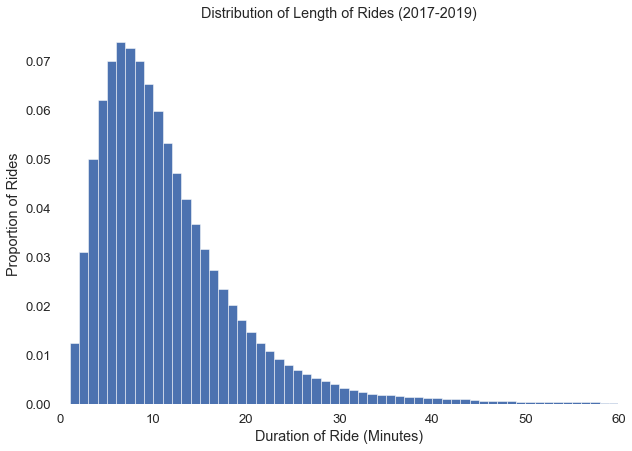

In [4]:
bins = np.arange(0, Cleaned_Data['duration_min'].max()+1, 1)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.distplot(Cleaned_Data['duration_min'], bins=bins, kde=False, norm_hist=True, hist_kws={"linewidth": 0.5,
                            "alpha": 1, "color": "b"})
ax.set(xlabel="Duration of Ride (Minutes)", ylabel = "Proportion of Rides", 
       title = 'Distribution of Length of Rides (2017-2019)')
plt.xlim([0,60]);
plt.box(on=None)
plt.savefig('Distribution of Length of Rides.png')

#### During weekdays there is a large surge of usage during work transit. The surge comes from subscribers. This implies that they probably use it on a daily basis. Bike usage is much lower during the weekends, and are spread out throughout the day. Very few percentage of the subscribers use bikes during the weekends.

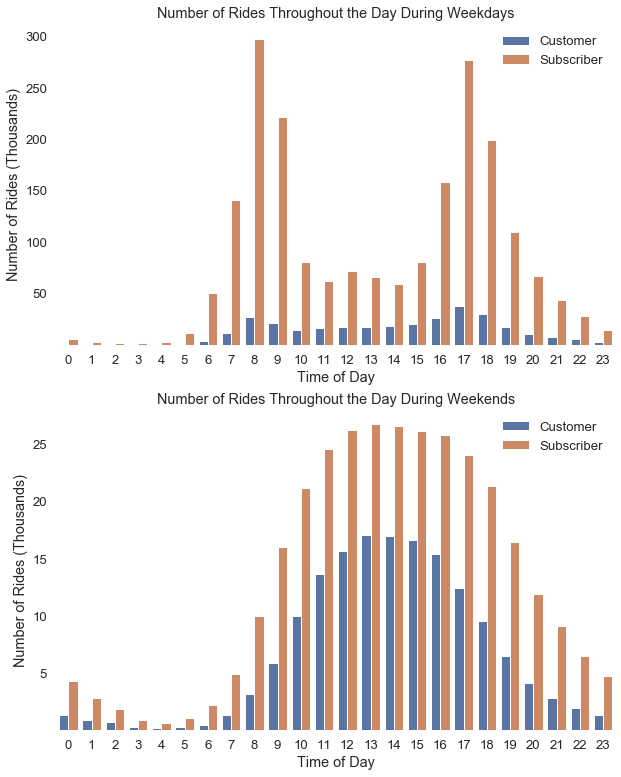

In [5]:
# Separating data between the weekend and weekday
weekday_data = Cleaned_Data.loc[Cleaned_Data['Day_of_Week_num']<5,:]
weekend_data = Cleaned_Data.loc[Cleaned_Data['Day_of_Week_num']>4,:]
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'axes.grid' : False})
# Plotting Weekday
sns.set(font_scale=1.2)
plt.figure(figsize=(10,13))
plt.subplot(211)
ax = sns.countplot(data = weekday_data, x = 'Hour', hue = 'Type of User');
ax.set(xlabel="Time of Day", ylabel = "Number of Rides (Thousands)", 
       title = 'Number of Rides Throughout the Day During Weekdays');
plt.yticks(1000*np.array([50, 100, 150, 200, 250, 300]), ('50', '100', '150', '200', '250', '300'));
plt.legend(frameon=False);
plt.box(on=None)
# Plotting Weekend
plt.subplot(212)
ax2 = sns.countplot(data = weekend_data, x = 'Hour', hue = 'Type of User');
ax2.set(xlabel="Time of Day", ylabel = "Number of Rides (Thousands)", 
       title = 'Number of Rides Throughout the Day During Weekends');
plt.yticks(1000*np.array([5, 10, 15, 20, 25]), ('5', '10', '15', '20', '25'));
plt.legend(frameon=False);
plt.box(on=None)
plt.savefig('Number of Rides Throughout the Day.png')

#### Ride membership is always primarily subscribers. Customer membership seems somewhat steady, but subscriber membership varies more.

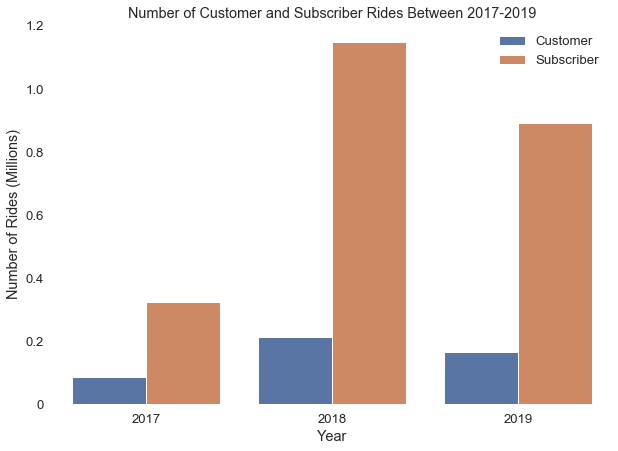

In [6]:
# Plotting Bike Share Usage as a Fuction of Time
plt.figure(figsize=(10,7))
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.countplot(x='Year', hue='Type of User', data=Cleaned_Data)
plt.legend(frameon=False);
plt.box(on=None);
ax.set(ylabel = "Number of Rides (Millions)", title = 'Number of Customer and Subscriber Rides Between 2017-2019');
plt.yticks(100000*np.array([0, 2, 4, 6, 8, 10, 12]), ('0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2'));
plt.savefig('Number of Rides Between 2017 to 2019.png')

#### Link to CARTO map:
https://rrungta101.carto.com/builder/d9e8c261-ae37-436e-8171-8e7ee4fdff3b/embed

In [7]:
# Exporting a CSV for easy mapping of station locations in CARTO
CSV_Data = Cleaned_Data.drop_duplicates(subset=['end_station_id'], keep='first').sort_values(by=['end_station_id'])
CSV_Data = CSV_Data[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']]
destinations = Cleaned_Data.groupby('end_station_id').count()[['end_time']]
CSV_Data = CSV_Data.merge(destinations, how='left', left_on='end_station_id', right_on='end_station_id').rename(
    columns={"end_station_id": "Station ID", "end_station_name": "Station Name", 
             "end_station_latitude": "Latitude", "end_station_longitude": "Longitude", 
             "end_time": "Trip Destinations"})
origins = Cleaned_Data.groupby('start_station_id').count()[['start_time']]
CSV_Data = CSV_Data.merge(origins, how='left', left_on='Station ID', right_on='start_station_id').rename(
    columns={"start_time": "Trip Origins"}).fillna(0)
CSV_Data = CSV_Data.astype({'Trip Origins': 'int'})
CSV_Data['Destination to Origin Ratio'] = CSV_Data['Trip Destinations']/CSV_Data['Trip Origins']
CSV_Data['Total Trips'] = CSV_Data['Trip Destinations'] + CSV_Data['Trip Origins']
CSV_Data.to_csv('CSV_Data_Export.csv', index = False, header=True)